# Python-Based RRKM code (test version)

So far this code work for single steps, and does not include rotational energies.

Missing features (to be implemented):

- Capture theory block
- Rotational energy (J's)
- Sum of rotational energy levels
- Translational density of states
- Master equation
- Non harmonic vibrational density/sum of states (Witten-Rabinovitch)

Developed by: **Joan Enrique-Romero** (Universitat Autonoma de Barcelona & Université Grenoble Alpes).

Based on the inhouse developed code by Dimitrios Skouteris + bilbiography and needs.

NB: there are 2 local repositories, `my_CALC_functions` and `my_PLOTTING_functions`, which contain most of the functions to be used for calculations and or plotting. The plotting ones were made for my own purposes so you may want to make your own.

In [64]:
#### Importing packages and defining some variables

import numpy as np
import math, time, importlib, sys
from numba import jit, objmode
import matplotlib.pylab as plt
importlib.reload(sys.modules['my_CALC_functions'])
importlib.reload(sys.modules['my_PLOTTING_functions'])
#importlib.reload(sys.modules['my_READIN_functions'])
import my_CALC_functions as  kinCALC
from my_CALC_functions import *
import my_PLOTTING_functions as kinPLOT
from my_PLOTTING_functions import *
import my_IO_functions as kinIO
#### --- --- --- Modify cell widths for better confort
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
##
##
#### --- --- --- Some constants and conversion factors
NA          = 6.022e23 # mol-1
c           = 29979245800 # cm/s
h           = 6.62607004e-34 # Js
har_to_cm1  = 219474.63
kJmol_to_J  = 1000./NA
J_to_cm1    = 5.03445e22
kJmol_to_cm1= 83.59345392546533 
har_to_J    = 43.60e-19


## Input

Generate an input file following these rules:

- There are 2 types of sections:```-- GLOBAL --``` and ``` -- STEP i --```
- Each section contains variable names and values, they are spearated by a semincolon ``` : ```
- Comments with ``` # ```
- Some variables need/allow more than one input, sperate them with a comma ``` , ```
- Example:

```
-- GLOBAL --
dE (kJ/mol):       0.01
nEpts (int):       15000
Ein (kJ/mol):      0.01
Emin (kJ/mol):     0.0
maxT (int, K):     150
num_steps (int):   3
ROT_Dens (Rot in DensStat?, Bool):  True
TUN (tunnel?,all,no*,nrs steps): all  
dir_out (str,path): OUT_TEST
#----------------------------------------------------------------------
-- STEP 1 --
name (str):            HCO_Christian
vibr_rg (str,path):    INP/FRQS_R_CO_Hydr.txt, 1
vibr_ts (str,path):    INP/FRQS_R_CO_Hydr.txt, 2
Rct_rg (floats, GHz):  0.18784, 0.13383, 0.10628
Rct_ts (floats, GHz):  0.18826, 0.13386, 0.10573
Erg (float,kJ/mol):    0.0
Ets (float,kJ/mol):    11.42830265500080
Epr (float,kJ/mol):    -89.5322280099476
#----------------------------------------------------------------------
-- STEP 2 --
...
...
```

In [58]:
GLOBALS, DATA_STEPS = kinIO.READ_INPUT("/Users/enriquej/Desktop/CALC/Python/myRRKM/INP/test_cases.dat")
kinCALC.GLOBALS = GLOBALS # passing globals to CALC
print(GLOBALS)
#print(DATA_STEPS)

Default printing level is Normal
Default sanity check is True
NOTE: kJ/mol were converted into cm-1
{'dE': 0.8359345392546533, 'nEpts': 15000, 'Ein': 0.8359345392546533, 'Emin': 0.0, 'maxT': 150, 'num_steps': 3, 'ROT_Dens': True, 'TUN': [0, 1, 2], 'dir_out': 'OUT_TEST', 'Printing_level': 'N', 'Sanity_Check': 'True'}


## Run the code

- The Beyer-Swinehart algorithm can be reached with the function 

   ```BeyerSwinehart(E_grid,NormModes,E_StatPoint,nEpts,dE,Ein,Emin,dens=np.array([None]))```
    
   Where ```E_StatPoint``` is the energy of the PES item (reactants/ts), and ```dens``` could be a previously calculated/initiated Density/Sum of states. For example, one could feed in the rotational density/sum of states. On the other hand, one could introduce an array of the length of E_grid, filled only with 1.0, this way one would obtain a pure vibrational sum of states.


- From a denisty of states, one can calculate a Sum of states by using the ```Sum_States``` function:

    ```Sum_States(E_grid,dens,barrier_E,bkg_barrier_E,dE,Ein,Emin,tn=False,ts_frq=0)```
    
    Where ```barrier_E``` and ```bkg_barrier_E``` are the forward and backward reaction barriers. The backward one is only necessary when tunnelling is desired, which then takes an asymmetric Eckart potential. For that make sure to have ```tn=True``` and to add the frequency of the TS: ```ts_frq```. Notice that if tunneling is set on and no backward barrier is given, the code will automatically adopt a symmetric Eckart potential.

--------------

- In order to calculate the k(E) run ```micocan_kE(N,p,nEpts)``` where `p` is the density of states of reagents and `N` the sum of states of the TS.

- Then you will need to calculate the partition function with `calculate_part_function(E_grid,dens,maxT,nEpts)`.

- Finally the k(T) with `calcuate_rate_T(E_grid,kE,dens,maxT,PF,nEpts)` where PF is the partition function.

--------------

All the functions provide timings.

Starting calculation...


 ---- Step 1/3 took 5.87 s


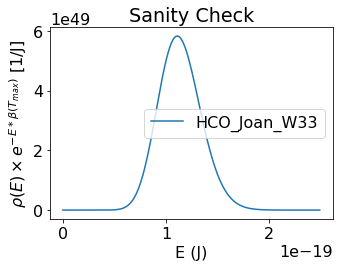

 ---- Step 2/3 took 7.09 s


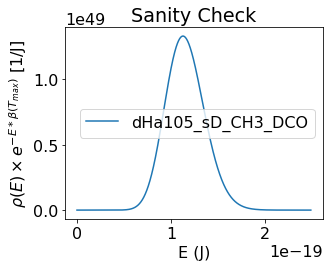

 ---- Step 3/3 took 6.23 s
Done

CPU times: user 50.6 s, sys: 29.2 s, total: 1min 19s
Wall time: 19.4 s


In [66]:
%%time
#Main loop
print("Starting calculation...")

for istep, STEP in enumerate(DATA_STEPS[:]):
    
    time_step = time.time()
    if GLOBALS["Printing_level"]=='D': print("Step {}/{}".format(istep+1,len(DATA_STEPS)))
    
    ##------ Preparing E_grid
    nEbts_barr = kinCALC.round_numb(STEP['Ets']/GLOBALS['dE'])
    nEpts_TOT  = GLOBALS['nEpts']+nEbts_barr
    E_grid     = kinCALC.make_Egrid(GLOBALS["Ein"],GLOBALS["dE"],nEpts_TOT)
    
    ##------ Densities and sums of states
    if GLOBALS["Printing_level"]=="D":print(" # Running Density of States for reactants and ts...")
    d0_rg, d0_ts = np.array([-1]),np.array([-1])
    if GLOBALS["ROT_Dens"]:
        d0_rg = kinCALC.rot_dens(E_grid,STEP['Erg'],STEP['Rct_rg'])
        d0_ts = kinCALC.rot_dens(E_grid,STEP['Ets'], STEP['Rct_ts'])
    dens_rg  = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_rg'][ :],STEP['Erg'],nEpts=nEpts_TOT,dens=d0_rg)
    dens_ts  = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_ts'][1:],STEP['Ets'],nEpts=nEpts_TOT,dens=d0_ts)
    
    if GLOBALS["Printing_level"]=='D': print(" # Running Sums of States for ts...")
    sumts_integ = kinCALC.Sum_States(E_grid,dens_ts,barrier_E=STEP['Ets'])
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        sumts_integ_tun = kinCALC.Sum_States(E_grid,dens_ts,barrier_E=STEP['Ets'],bkg_barrier_E=(STEP['Ets']-STEP['Epr']),tn=True,ts_frq=STEP['vibr_ts'][0])
    
    if GLOBALS["ROT_Dens"]:
        init_sum = kinCALC.rot_sum(E_grid,STEP['Ets'], STEP['Rct_ts'])
    else:
        init_sum = np.zeros(nEpts_TOT) # exact count
        for i, d in enumerate(init_sum):
            if i >= kinCALC.find_bin(STEP['Ets'],GLOBALS['dE'],E_grid): init_sum[i]=1.0
    sumts_bs = kinCALC.BeyerSwinehart(E_grid,STEP['vibr_ts'][1:],STEP['Ets'],nEpts=nEpts_TOT,dens=init_sum)
    
    ##------ K(E) and K(T) calculation
    if GLOBALS["Printing_level"]=='D': print(" # Running kE and kT calculations...")
    kE = kinCALC.micocan_kE(N=sumts_integ,p=dens_rg)
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kE_tun = kinCALC.micocan_kE(N=sumts_integ_tun,p=dens_rg)
    kE_bs = kinCALC.micocan_kE(N=sumts_bs, p=dens_rg)
    
    PartFun = kinCALC.calculate_part_function(E_grid,dens=dens_rg)
    
    kT = kinCALC.calcuate_rate_T(E_grid,kE=kE ,dens=dens_rg,PF=PartFun)
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kT_tun = kinCALC.calcuate_rate_T(E_grid,kE=kE_tun,dens=dens_rg,PF=PartFun)
    kT_bs = kinCALC.calcuate_rate_T(E_grid,kE=kE_bs ,dens=dens_rg,PF=PartFun)
    
    #------ STORING DATA
    STEP["E_grid"]  = E_grid
    STEP["dens_rg"] = dens_rg
    STEP["dens_ts"] = dens_ts
    STEP["sumts_integ"] = sumts_integ
    STEP["sumts_bs"] = sumts_bs
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]: 
        STEP["sumts_integ_tun"] = sumts_integ_tun
    #
    STEP["kE"] = kE
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]: 
        STEP["kE_tun"] = kE_tun
    STEP["PartFun"] = PartFun
    STEP["kT"] = kT
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        STEP["kT_tun"] = kT_tun
    STEP["kE_bs"] = kE_bs
    STEP["kT_bs"] = kT_bs

    # SANITY CHECKs
    if GLOBALS['Sanity_Check']:
        kinCALC.SanityCheck(GLOBALS['maxT'],STEP)
    
    print(" ---- Step {}/{} took {:.2f} s".format(istep+1,len(DATA_STEPS),time.time()-time_step))
    
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_dens_states.csv".format(STEP['name']),
                       cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,dens_rg[:GLOBALS['nEpts']]*J_to_cm1,dens_ts[:GLOBALS['nEpts']]*J_to_cm1],
                       header='E[J],    dens_rg[J-1],    dens_ts[J-1]')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_sum_states.csv".format(STEP['name']),
                          cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,sumts_integ[:GLOBALS['nEpts']],sumts_integ_tun[:GLOBALS['nEpts']]],
                          header='E[J],    sum_states,    sum_states_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_kE.csv".format(STEP['name']),
                       cols=[E_grid[:GLOBALS['nEpts']]/J_to_cm1,kE[:GLOBALS['nEpts']],kE_tun[:GLOBALS['nEpts']]],
                       header='E[J],    kE[s-1],    kE_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_kT.csv".format(STEP['name']),
                       cols=[np.array([i+1 for i in range(GLOBALS["maxT"])]),np.array([1./(i+1.) for i in range(GLOBALS["maxT"])]),kT,kT_tun],
                       header='T[K],    1/T[K-1],    kT[s-1],    kT_tun')
        kinIO.STORE_into_CSV(path=GLOBALS['dir_out']+"/{}_PartFn.csv".format(STEP['name']),
                       cols=[np.array([i+1 for i in range(GLOBALS["maxT"])]),PartFun*J_to_cm1],
                       header='T[K],    PartFn[J-1]')


        
        # part fn in dens units (1/cm-1), convert into 1/J (*J_to_cm1)
        
print('Done\n')




## Plotting

In [60]:
# You can compare with Skouteri's data:
dirname_s1 = "/Users/enriquej/Desktop/CALC/RRKM_Christian/CO_CS_Christian/OUT/"
dirname_s2 = "/Users/enriquej/Work/1_NOTESnRESULTS/Article_Arezu/CALC/H_CO__HCO__M08HX/"
dirname_s3 = "/Users/enriquej/Desktop/CALC/Deuterated_HCO_CH3_W33_spTZ__unsymm/OUT/"

Sk_tot_dens_s1    = dirname_s1 + "totDENS_w18_COhyd_TS.csv"
Sk_csv_file_kE_s1 = dirname_s1 + "kE_cla_eck_w18_COhyd_TS.csv"
Sk_csv_file_kT_s1 = dirname_s1 + "rate_constants/w18_COhyd.csv"

Sk_tot_dens_s2    = dirname_s2 + "totDENS_ts_Frq_dZ.csv"
Sk_csv_file_kE_s2 = dirname_s2 + "kE_cla_eck_ts_Frq_dZ.csv"
Sk_csv_file_kT_s2 = dirname_s2 + "rate_constants/rates_ts_Frq_dZ.csv"

Sk_tot_dens_s3    = dirname_s3 +"totDENS_sD_dHa_ts_CH3_HCO_105.csv"
Sk_csv_file_kE_s3 = dirname_s3 +"kE_cla_eck_sD_dHa_ts_CH3_HCO_105.csv"
Sk_csv_file_kT_s3 = dirname_s3 +"rate_constants/rate_sD_dHa_ts_CH3_HCO_105.csv"

Sk_tot_dens    = [Sk_tot_dens_s1,Sk_tot_dens_s2,Sk_tot_dens_s3]
Sk_csv_file_kE = [Sk_csv_file_kE_s1,Sk_csv_file_kE_s2,Sk_csv_file_kE_s3]
Sk_csv_file_kT = [Sk_csv_file_kT_s1,Sk_csv_file_kT_s2,Sk_csv_file_kT_s3]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


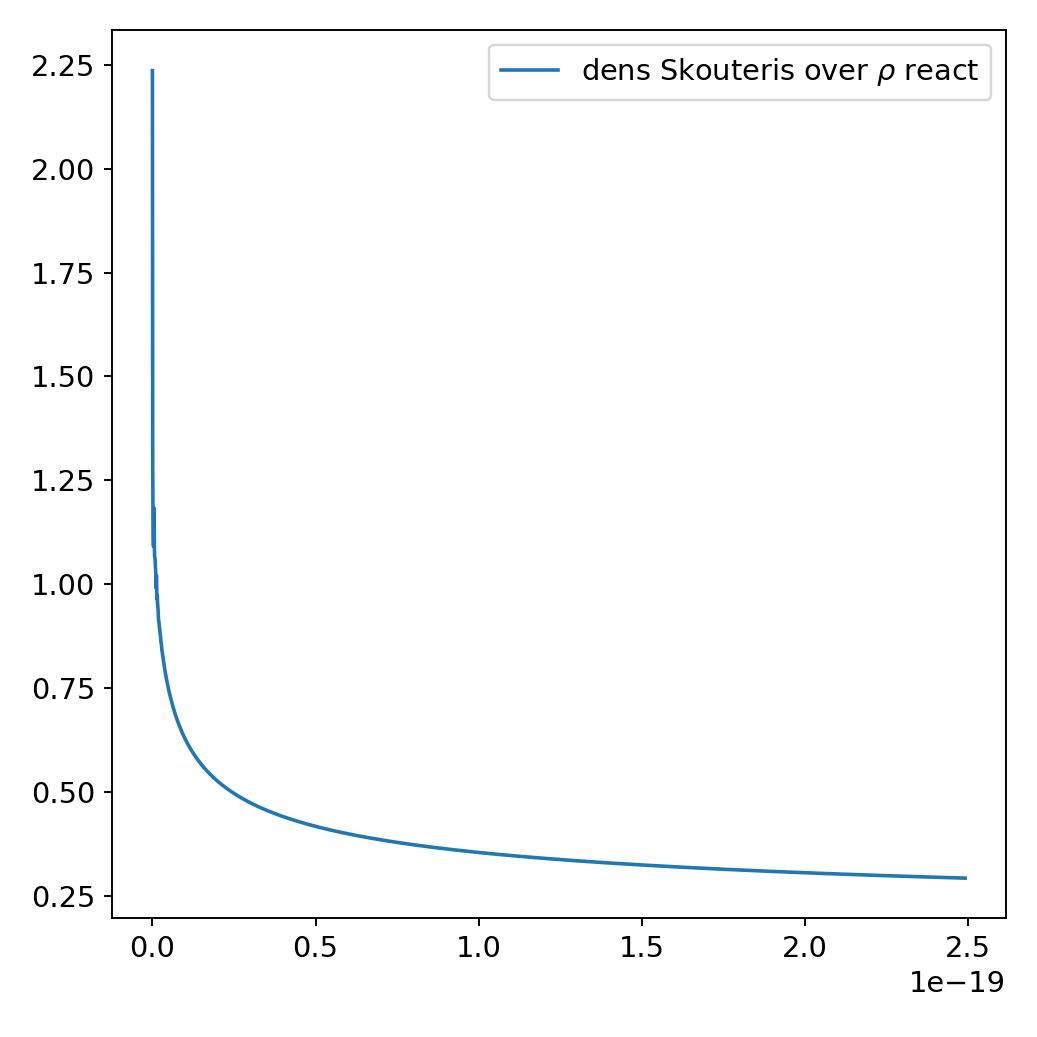

<IPython.core.display.Javascript object>


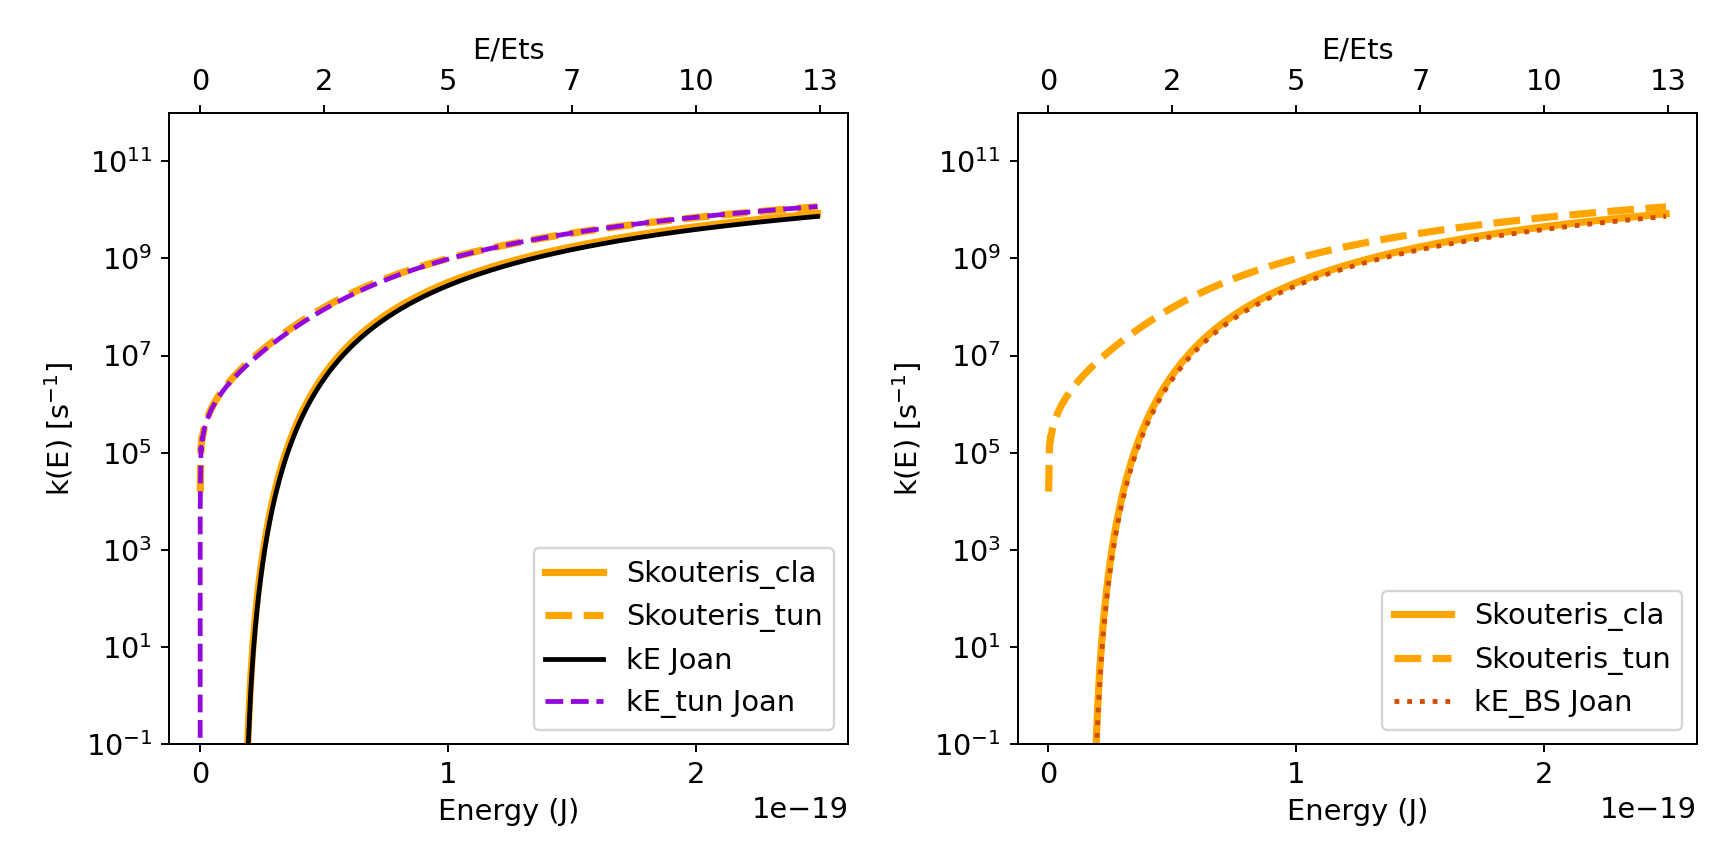

<IPython.core.display.Javascript object>


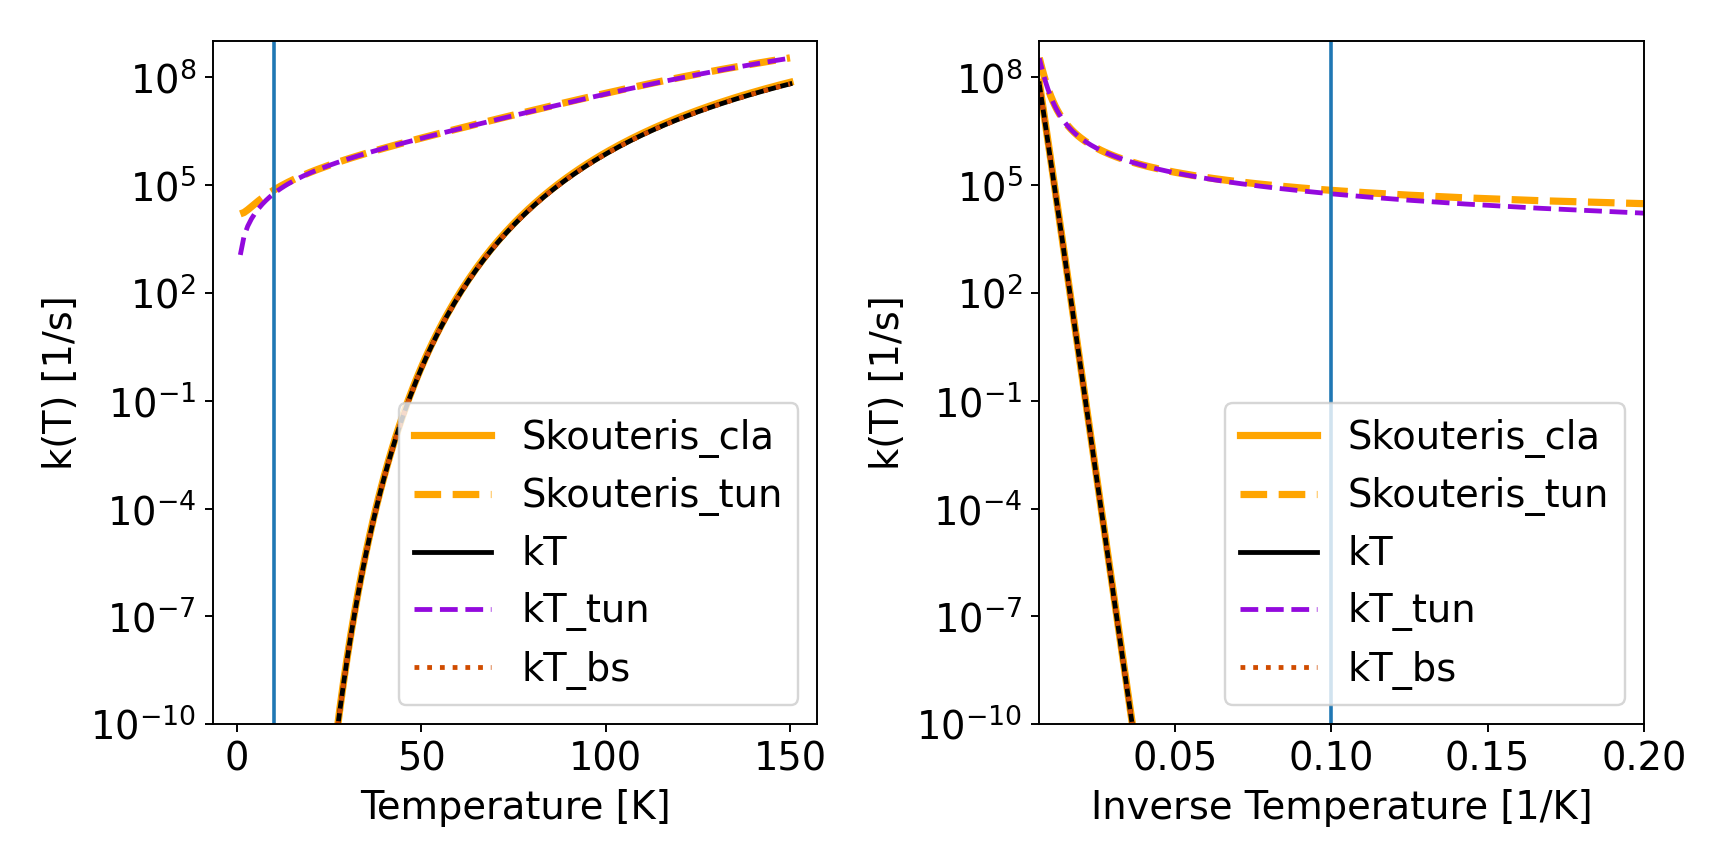

>> Tun probab took: 0.00 s


<IPython.core.display.Javascript object>


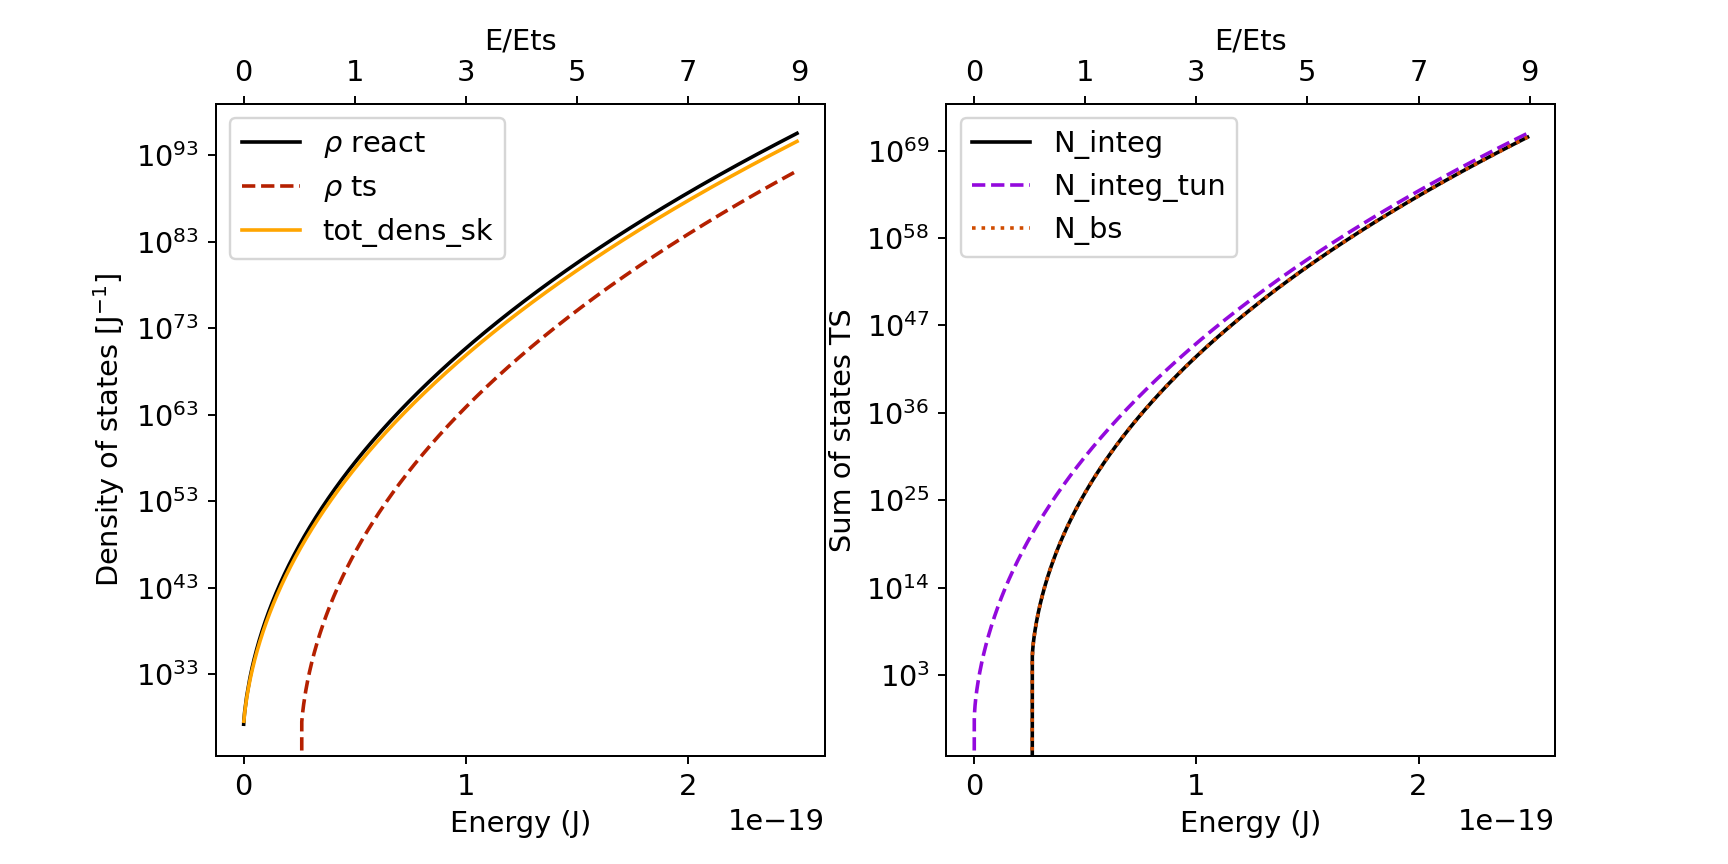

<IPython.core.display.Javascript object>


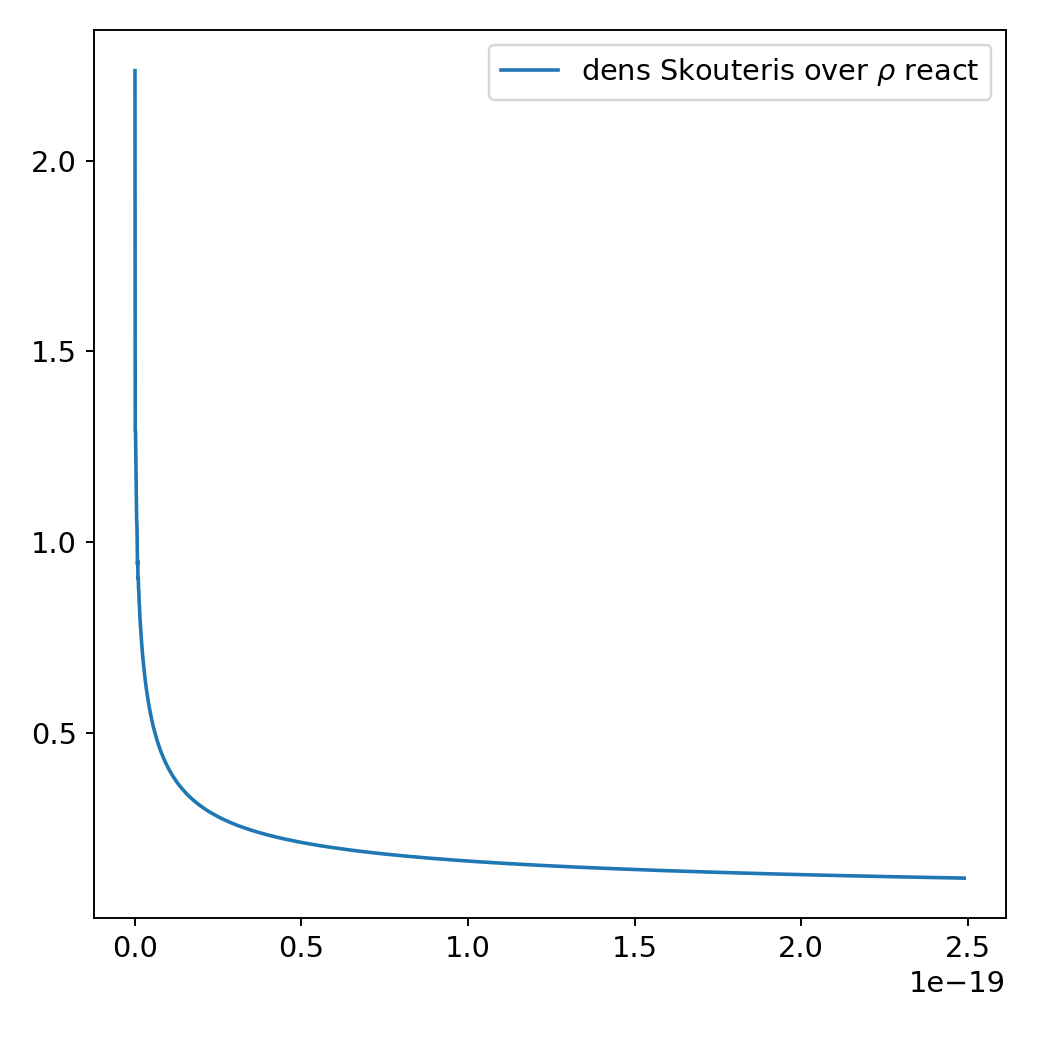

<IPython.core.display.Javascript object>


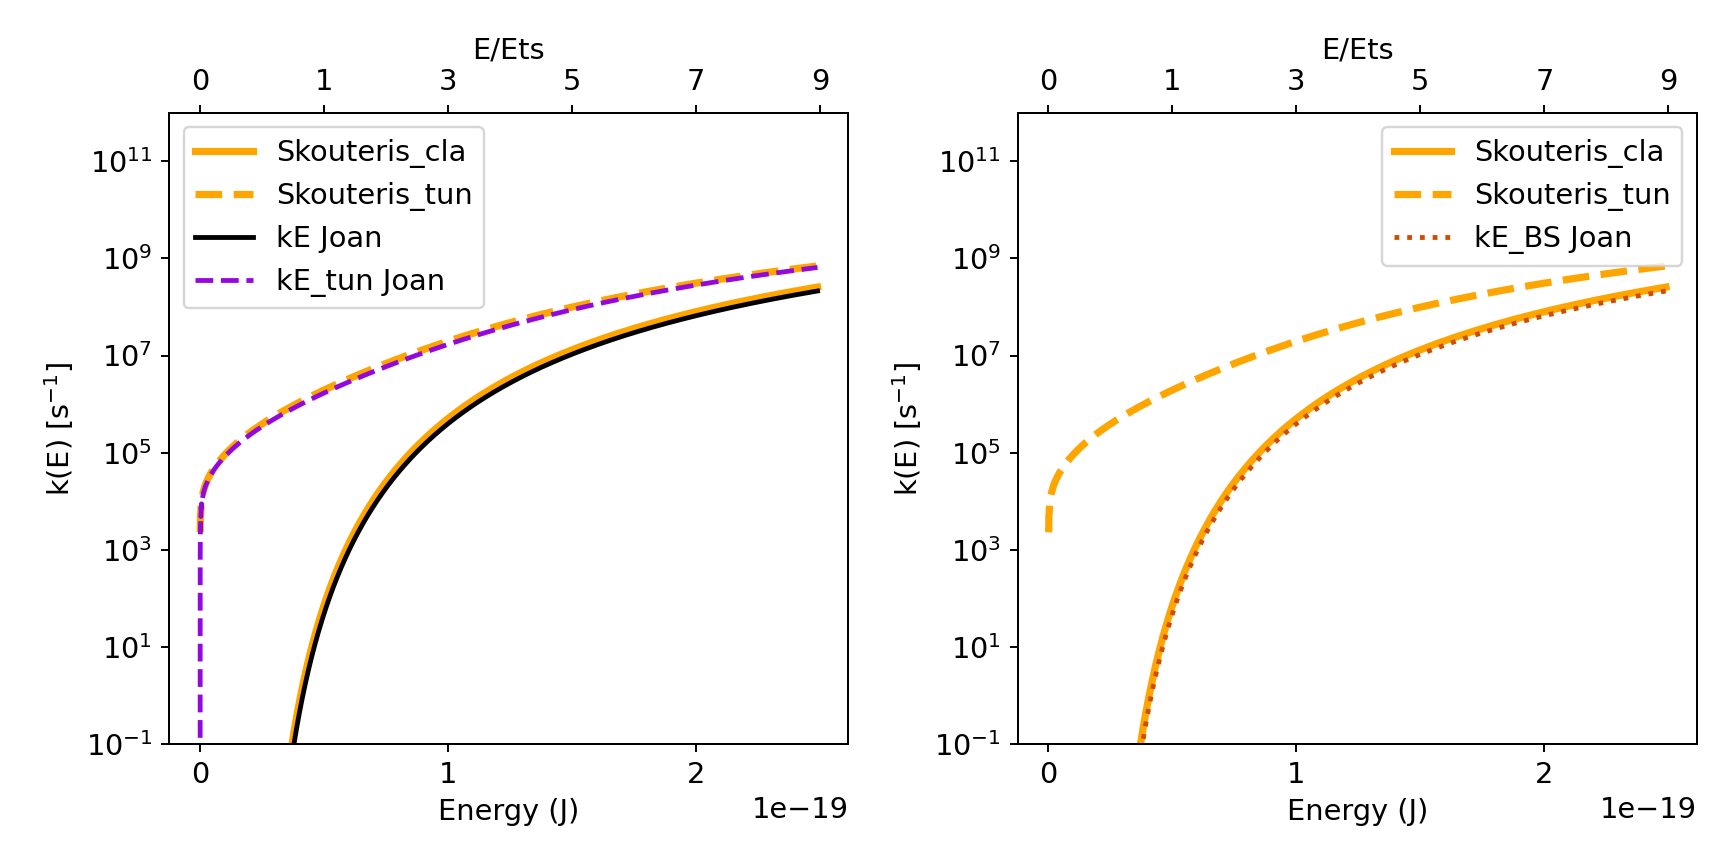

<IPython.core.display.Javascript object>

>> Tun probab took: 0.00 s


<IPython.core.display.Javascript object>


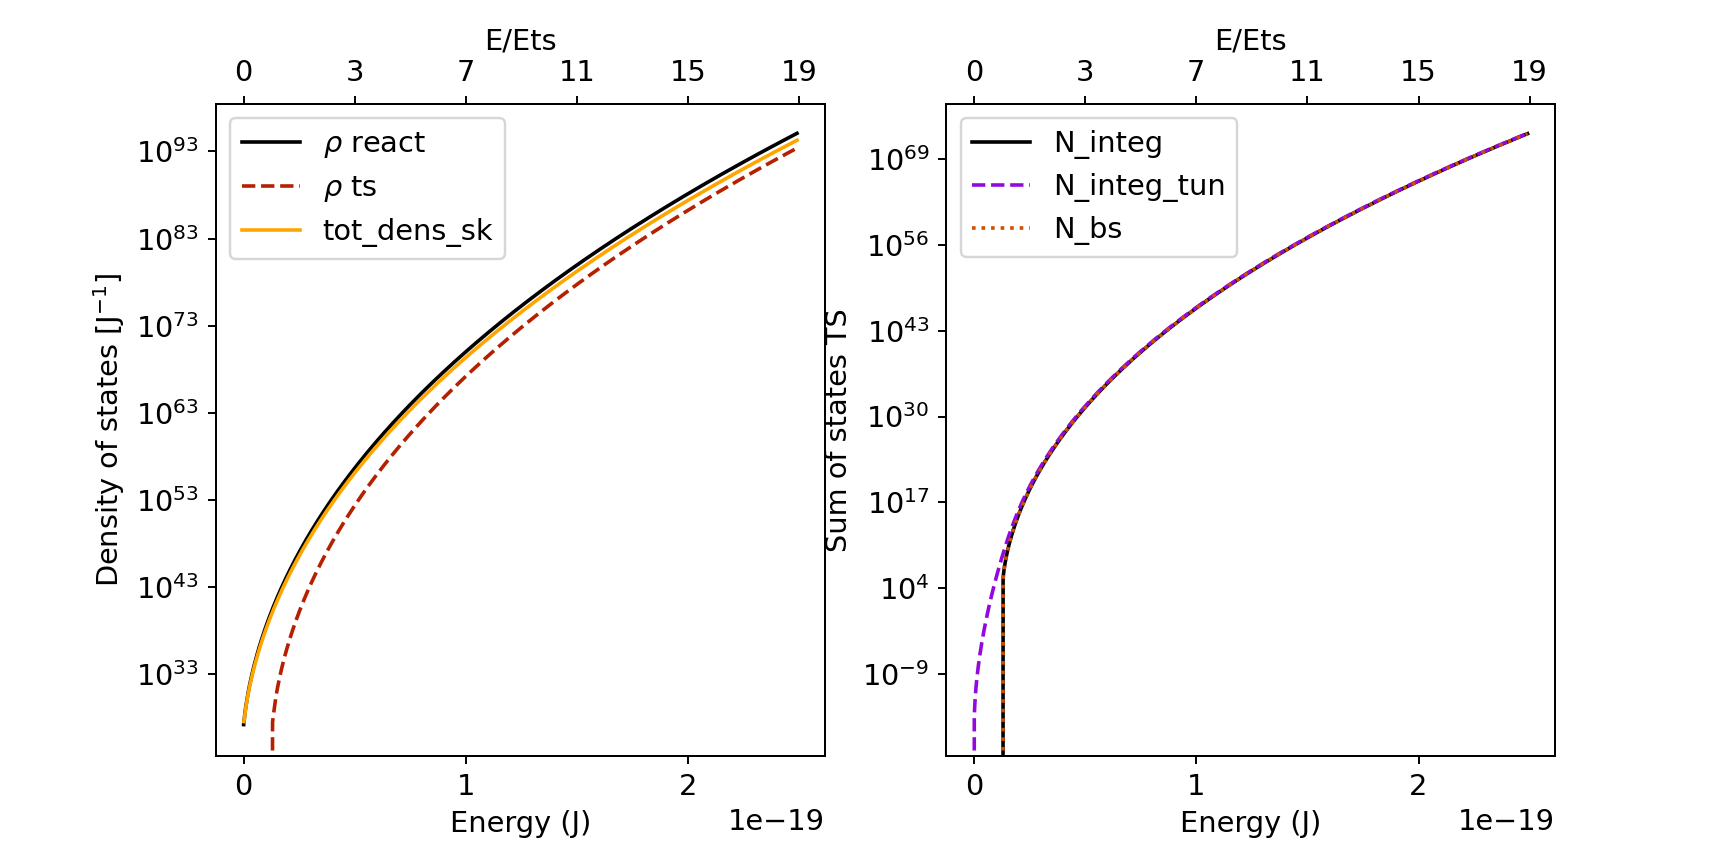

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


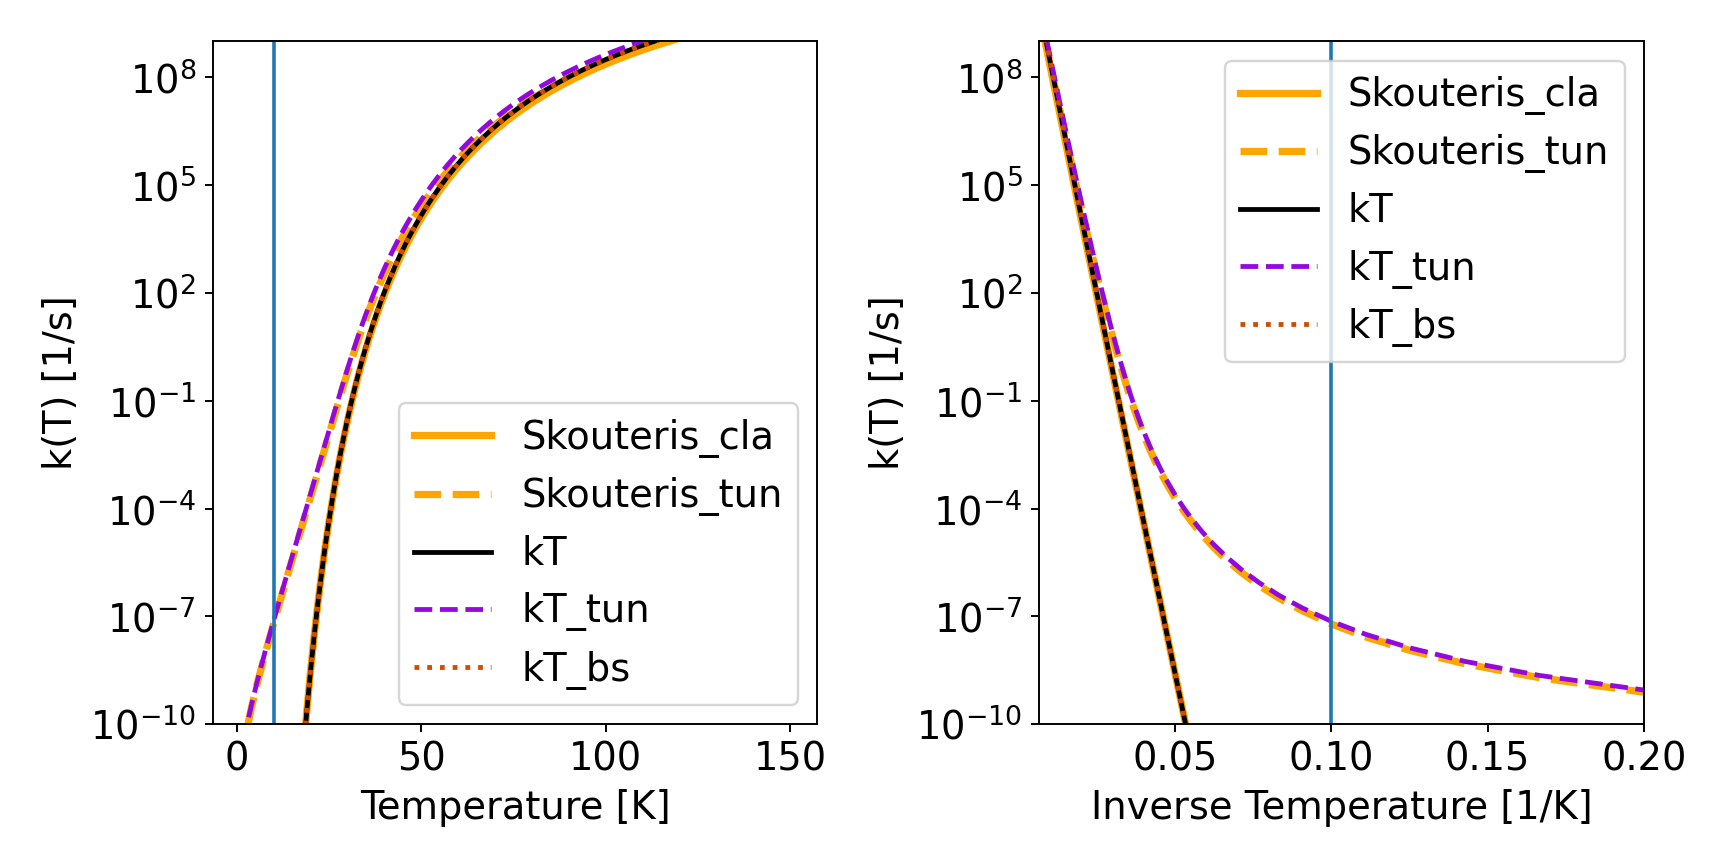

>> Tun probab took: 0.00 s


In [68]:
%matplotlib notebook
#%matplotlib inline
def add_Xaxis_EoverEref(ax,Eref):
    # ax must be a list
    dummy_axes = [ax[0].twiny(),ax[1].twiny()]
    for i in [0,1]:
        dummy_axes[i].set_xticks( ax[i].get_xticks() )
        dummy_axes[i].set_xbound( ax[i].get_xbound() )
        dummy_axes[i].set_xticklabels( [int(e/Eref) for e in ax[i].get_xticks()])
        dummy_axes[i].set_xlabel("E/Ets")
def theta(E_grid,v0):
    result = np.zeros(len(E_grid))
    for i,e in enumerate(E_grid):
        if e>v0: result[i]=1.
    return result

for istep,STEP in enumerate(DATA_STEPS):
    ##################################
    ##------ PLOT dens and sum of states
    ##################################
    lisD  = [STEP['dens_rg'],STEP['dens_ts']]
    lisnD = [r"$\rho$ react",r"$\rho$ ts"]
    lisS  = [STEP['sumts_integ'],STEP['sumts_integ_tun'],STEP['sumts_bs']]
    lisnS = ["N_integ","N_integ_tun","N_bs"]
    r_N_axs = plot_rho_and_N(STEP['E_grid'] / J_to_cm1,lisD,lisnD,lisS,lisnS,GLOBALS['nEpts'],Xaxis_label="Energy (J)",conv_units='cm1_to_J',Sk_tot_dens=Sk_tot_dens[istep])
    # Upper X axis
    add_Xaxis_EoverEref(r_N_axs,STEP['Ets']/J_to_cm1)
    #
    plt.tight_layout()
    plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_Dens_Sums.png",dpi=200)
    plt.show()
    

    ##################################
    ##------ PLOT k(E)
    ##################################
    liskE  = [STEP['kE'], STEP['kE_tun'], STEP['kE_bs']]
    lisnkE = ["kE Joan","kE_tun Joan", "kE_BS Joan"]
    ke_axs = plot_kE(STEP['E_grid'],GLOBALS['nEpts'], liskE, lisnkE, Sk_csv_file=Sk_csv_file_kE[istep])
    for ax in ke_axs: ax.set_ylim([1e-1,1e12])
    # Upper X axis
    add_Xaxis_EoverEref(ke_axs,STEP['Ets']/J_to_cm1)
    #
    plt.tight_layout()
    plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_kE.png",dpi=200)
    plt.show()
    ##################################
    ##------ PLOT k(T)
    ##################################
    #
    lisK  = [STEP['kT'] , STEP['kT_tun'], STEP['kT_bs']]
    lisnK = ["kT","kT_tun","kT_bs"]
    #
    kt_axes = plot_kT(GLOBALS['maxT'],lisK,lisnK, Sk_csv_file=Sk_csv_file_kT[istep])
    kt_axes[0].set_ylim([1e-10,1e9])
    kt_axes[0].axvline(x=10.0)
    kt_axes[1].set_ylim([1e-10,1e9])    
    kt_axes[1].set_xlim([1./150.,1./5.])
    kt_axes[1].axvline(x=1./10.0)
    plt.tight_layout()
    plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_kT.png",dpi=200)
    plt.show()
    
    if GLOBALS["TUN"][0]!=-1 and istep in GLOBALS["TUN"]:
        #
        ##################################
        ##------ PLOT tunneling probab
        ##################################
        #
        t0 = time.time()
        #
        barr_Joules  = STEP['Ets']*c*h
        bbarr_Joules = (STEP['Ets']-STEP['Epr'])*c*h
        shifted_E    = STEP['E_grid']*c*h - barr_Joules
        ts_frq       = -STEP['vibr_ts'][0]*c
        #
        tunn_prob = T_Eck_unsym(STEP['E_grid']*c*h,v0=barr_Joules,v1=bbarr_Joules,frq=ts_frq)
        #tunn_prob = T_Eck_unsym(E_grid*c*h,v0=Ets*1000/6.022e23,v1=(Ets-Epr)*1000/6.022e23,frq=-vibr_ts[0]*29979245800)
        print(">> Tun probab took: {:.2f} s".format(time.time()-t0)) 
        #------------------------------------------------------------------------
        #

        plt.plot(shifted_E,T_Eck_unsym(STEP['E_grid']*c*h,v0=STEP['Ets']*c*h,v1=(STEP['Ets']-STEP['Epr'])*c*h,frq=-STEP['vibr_ts'][0]*c))
        plt.plot(shifted_E,theta(shifted_E,0))
        plt.plot(shifted_E,tunn_prob)
        plt.tight_layout()
        plt.savefig(GLOBALS["dir_out"]+"/"+STEP['name']+"_compare_tun.png",dpi=200)
        plt.show()


>> Tun probab took: 0.14 s


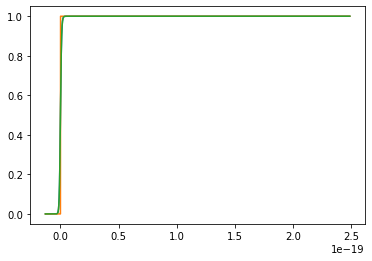

In [8]:
%matplotlib inline
def theta(E_grid,v0):
    result = np.zeros(len(E_grid))
    for i,e in enumerate(E_grid):
        if e>v0: result[i]=1.
    return result
#
t0 = time.time()
#
barr_Joules  = Ets*c*h
bbarr_Joules = (Ets-Epr)*c*h
shifted_E    = E_grid*c*h - barr_Joules
ts_frq       = -vibr_ts[0]*c
#
tunn_prob = T_Eck_unsym(E_grid*c*h,v0=barr_Joules,v1=bbarr_Joules,frq=ts_frq)
#tunn_prob = T_Eck_unsym(E_grid*c*h,v0=Ets*1000/6.022e23,v1=(Ets-Epr)*1000/6.022e23,frq=-vibr_ts[0]*29979245800)
print(">> Tun probab took: {:.2f} s".format(time.time()-t0)) 
#------------------------------------------------------------------------
#

plt.plot(shifted_E,T_Eck_unsym(E_grid*c*h,v0=Ets*c*h,v1=(Ets-Epr)*c*h,frq=-vibr_ts[0]*c))
plt.plot(shifted_E,theta(shifted_E,0))
plt.plot(shifted_E,tunn_prob)
plt.show()

## Bibliography:

- Baer & Hase 1996
- Henriksen et al. 2019


In [ ]:
# master eq